In [118]:
%matplotlib inline
# Additional Modules required
import copy
import os
import csv
import glob
import numpy as np
import matplotlib.pylab as plt
import nibabel as ni
import dicom as dcm

from scipy.ndimage.filters import median_filter
from scipy.ndimage.measurements import maximum_position
from scipy.ndimage.measurements import center_of_mass
from scipy.ndimage.filters import maximum_filter
from morphsnakesmaster import morphsnakes
from scipy.ndimage.interpolation import zoom as imgresize
from scipy import ndimage

from skimage.morphology import binary_closing, binary_opening
from skimage.measure import block_reduce
from ipywidgets import FloatProgress
from IPython.display import display
from pybxd.readBxdImage import read_bxd_image
from lmfit import minimize, Parameters
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from pynamika import *
from scipy.optimize import curve_fit

In [119]:
def circle_levelset(shape, center, sqradius, scalerow=1.0):
    """Build a binary function with a circle as the 0.5-levelset."""
    grid = np.mgrid[list(map(slice, shape))].T - center
    phi = sqradius - np.sqrt(np.sum((grid.T)**2, 0))
    u = np.float_(phi > 0)
    return u

In [120]:
def loadImages(PATH2IMG):
    """
    
    """        
    IMFID  = nib.load(PATH2IMG)
    IMDATA = IMFID.get_data()
    
    return IMDATA

In [175]:

ServerPath   = os.path.join(os.sep, 'Volumes' , 'S-TRI-16-17')
#Path2Data       = os.path.join(os.sep, ServerPath,  'R-TRI-16-16', 'volunteer-data', '001/20171020/SecondVisit')
Path2Data       = os.path.join(ServerPath,'Development', 'TestPulmolux','009')

Path2Data  =('/Volumes/Data/USZ-13-1/subject_data/OEMR_PZ10')

#Path2Data_OE_1       = os.path.join(Path2Data, 'OE')
Path2Data_OE_1       = os.path.join(Path2Data)
Path2InitialQC_OE_1     = os.path.join(Path2Data_OE_1, 'analysis-2016', 'initialQC')
Path2Results_OE_1       = os.path.join(Path2Data_OE_1, 'analysis-2016', 'results')
Path2Analyze_OE_1       = os.path.join(Path2Data_OE_1, 'analysis-2016', 'analyze-raw-images')
Path2Registered_OE_1    = os.path.join(Path2Data_OE_1, 'analysis-2016', 'analyze-registered-images')


In [181]:

Dyn_data_reg=np.zeros((128,128,15,90))
counter=0
counter2=0
ListOfFiles = os.listdir(Path2Registered_OE_1 )
for file in ListOfFiles:
    if (file.find('dyn')>-1) & file.endswith('.img') :
        DataF = loadImages(os.path.join(Path2Registered_OE_1 ,file));
        Dyn_data_reg[:,:,:,counter2]= DataF.squeeze()
        ind= file.find('tt')+2 #index of time stamp
        counter2+=1

    

In [182]:
img = Dyn_data_reg[:,:,:,0]
macwe = morphsnakes.MorphACWE(img, smoothing=1, lambda1=1, lambda2=1)
macwe.levelset = circle_levelset(img.shape, (Dyn_data_reg.shape[0]/2,Dyn_data_reg.shape[0]/2,Dyn_data_reg.shape[2]/2), 84)
morphsnakes.evolve_Novisual(macwe, num_iters=40)
SegmentationNew= macwe.levelset

Segmentation3dOut = binary_erosion(SegmentationNew, structure=np.ones((5,5,1)))


/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.f

0.56771654341


/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in less
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater


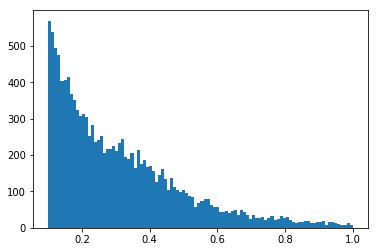

In [189]:
IntervalO2 = np.arange(40,60,1) #oxygen plateau
IntervalAir = np.arange(1,10,1)
IntervalAir_2 = np.arange(80,90,1)
EnO2d =np.nanmean(Dyn_data_reg[:,:,:,IntervalO2],3) - np.nanmean(Dyn_data_reg[:,:,:,IntervalAir],3)  
EnO2=(np.nanmean(Dyn_data_reg[:,:,:,IntervalO2],3) - np.nanmean(Dyn_data_reg[:,:,:,IntervalAir],3) )/ np.nanmean(Dyn_data_reg[:,:,:,IntervalAir],3)  
EnO2_2=(np.nanmean(Dyn_data_reg[:,:,:,IntervalO2],3) - np.nanmean(Dyn_data_reg[:,:,:,IntervalAir_2],3) )/ np.nanmean(Dyn_data_reg[:,:,:,IntervalAir],3)  

EnO2[SegmentationNew==0]=np.nan
a= plt.hist(EnO2.flatten(),100,range=[0.1,1])
List = a[1]
print(np.nanpercentile(EnO2,98))
Bigger = np.where(List>0.8)
Th1=np.nanpercentile(EnO2,98)
Th2=np.nanpercentile(EnO2_2,98)
MaskO2 = np.zeros(EnO2.shape)
MaskO2[EnO2<Th1]=np.nan
MaskO2[EnO2>1]=np.nan
MaskO2[EnO2>Th1]=1
MaskO2[EnO2_2<Th2]=np.nan
MaskO2[EnO2_2>1]=np.nan
MaskO2[0:20,:,:]=np.nan
MaskO2[108:128,:,:]=np.nan
MaskO2[:,0:20,:]=np.nan
MaskO2[:,108:128,:]=np.nan
MaskO2[SegmentationNew==0]=np.nan
MaskO2[MaskO2==0]=np.nan




/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in multiply


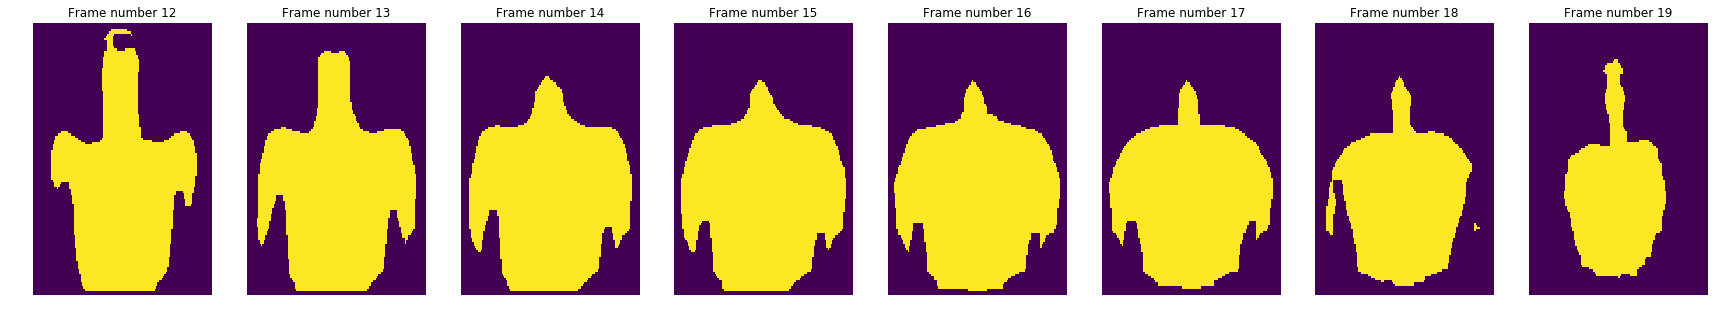

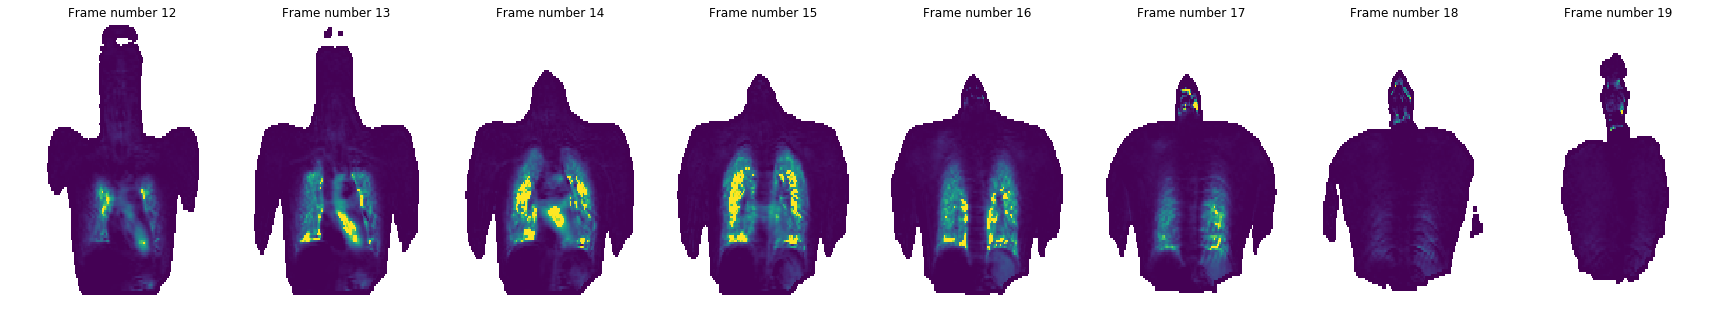

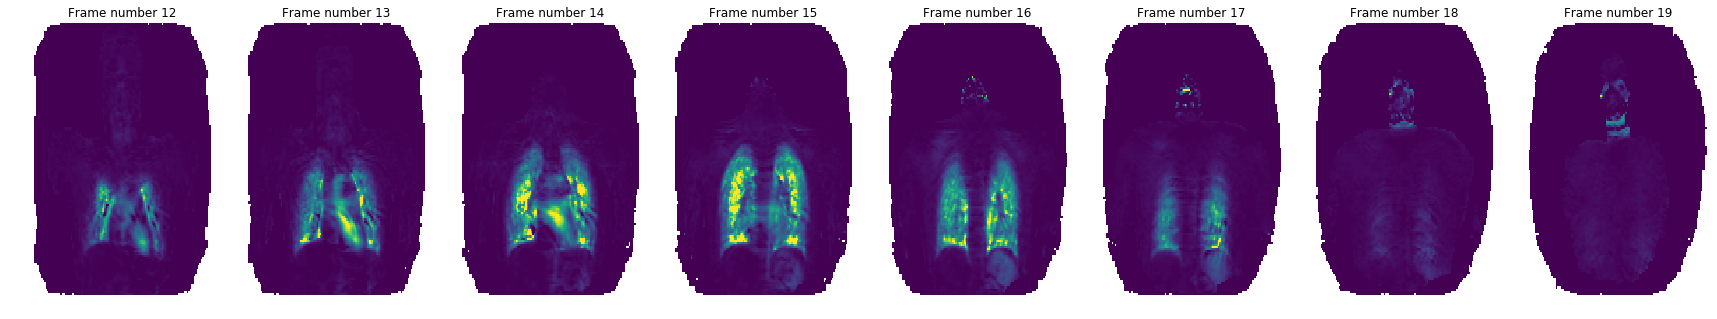

In [190]:
nrows=1
ncols=8
plt.figure( figsize=(30,5))
D=5
for i in range(8) :
    Slice =Segmentation3dOut[:,:,D+i] 
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto")
    plt.axis('off')
    plt.title('Frame number {0:.0f}'.format(i+12))
plt.figure( figsize=(30,5))
for i in range(8) :
    Slice =EnO2[:,:,D+i] *Segmentation3dOut[:,:,D+i] 
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1),vmax=1, vmin=0, aspect="auto")
    plt.axis('off')
    plt.title('Frame number {0:.0f}'.format(i+12))
for i in range(8) :
    Slice =MaskO2[:,:,D+i] *Segmentation3dOut[:,:,D+i] 
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1),vmax=1, vmin=0, aspect="auto")
    plt.axis('off')
    plt.title('Frame number {0:.0f}'.format(i+12))
plt.figure( figsize=(30,5))
for i in range(8) :
    Slice =EnO2_2[:,:,D+i] *SegmentationNew[:,:,D+i] 
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1),vmax=1, vmin=0, aspect="auto")
    plt.axis('off')
    plt.title('Frame number {0:.0f}'.format(i+12))

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


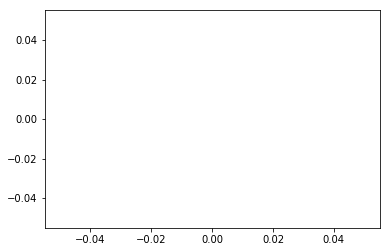

In [185]:
Masked=np.zeros(Dyn_data_reg.shape[:])
MaskedO2=np.zeros(Dyn_data_reg.shape[:])

MaskedMean=np.zeros((90))
MaskedMeanO2=np.zeros((90))

for ii in range (Dyn_data_reg.shape[3]):
    #Masked[:,:,:,ii] = Dyn_data_reg[:,:,:,ii]*MaskNaN 
    MaskedO2[:,:,:,ii] = Dyn_data_reg[:,:,:,ii]*MaskO2
   # MaskedMean[ii] = np.nanmean(Masked[:,:,:,ii])
    MaskedMeanO2[ii] = np.nanmedian(MaskedO2[:,:,:,ii])
#plt.plot(MaskedMean/np.max(MaskedMean))
MaskedMeanO2[np.isnan(MaskedMeanO2)]==0
MaskedMeanO2[np.isinf(MaskedMeanO2)]==0
plt.plot(MaskedMeanO2/np.max(MaskedMeanO2), '*r')
Signal = MaskedMeanO2/np.max(MaskedMeanO2)

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: Mean of empty slice
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: Mean of empty slice
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: Mean of empty slice
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: Mean of empty slice


2


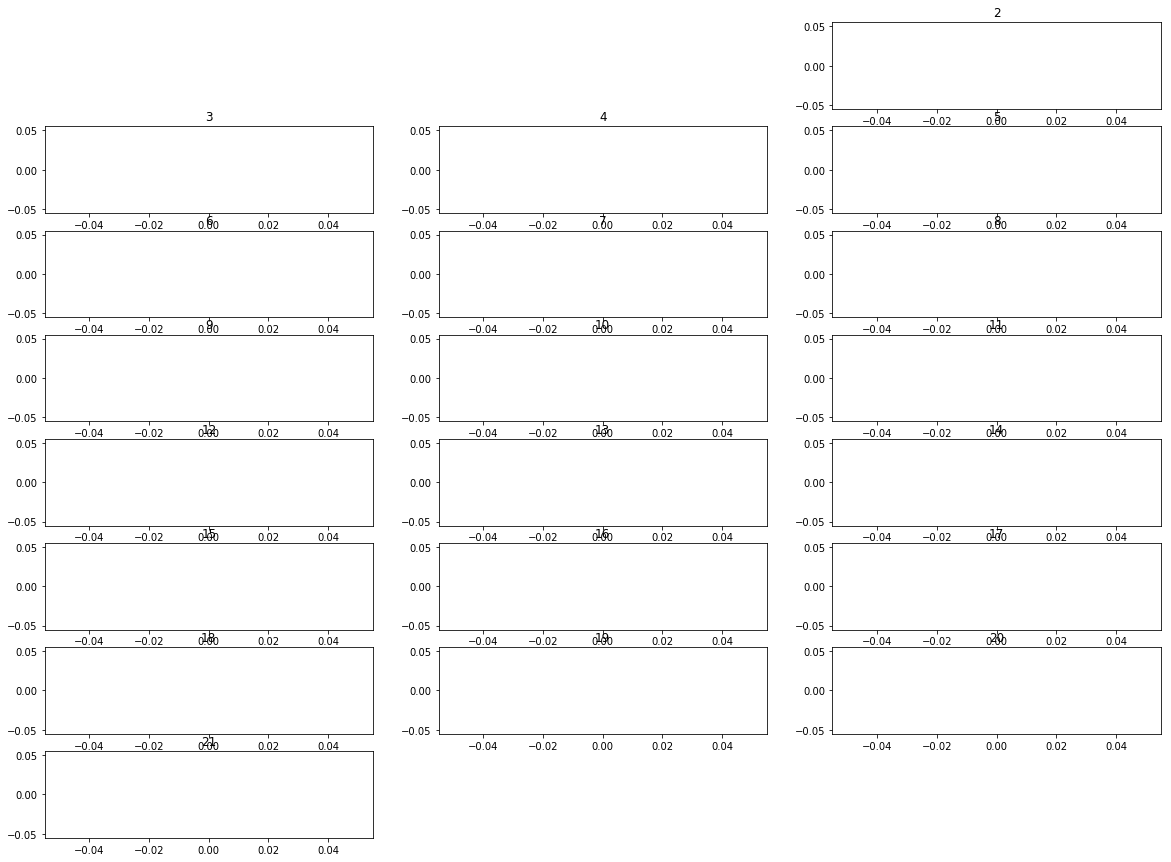

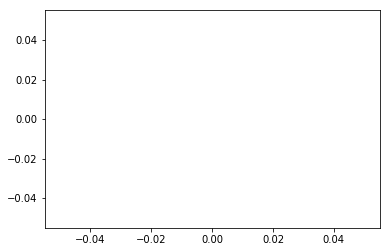

In [186]:
def funcExpUpFromZero(x,  b):
    return (1-np.exp(-b * x)) 
lastUp=50
interval = 22
TR=11
StartingPoint=2
del poptUp_Signal
timestamp=np.arange(0,(lastUp)*TR,TR)

poptUp_Signal=np.zeros((interval,3))
SumSq = np.zeros((interval,1))
perr=np.zeros((interval,3))
plt.figure(figsize=(20,15))

for delay in range(StartingPoint,interval):
    timestampUp = np.arange(0,(lastUp-delay)*TR,TR)
    MeanPre = np.nanmean(Signal[0:delay].squeeze())
    Signal1 = Signal - MeanPre
    MeanPost = np.nanmean(Signal1[lastUp-6:lastUp].squeeze())
    Uptake = Signal1[delay:lastUp].squeeze()/MeanPost
  
    Plateau = Signal[lastUp-10:lastUp].squeeze() -MeanPre
    aGuess =np.nanmean( Plateau)
    
    try:
        poptUp_Signal[delay,:],b=curve_fit(funcExpUpFromZero, timestampUp, Uptake, p0=[0.03])
    except:
        poptUp_Signal[delay,:]=[0,10,0]
 
        
    d =funcExpUpFromZero(timestampUp,poptUp_Signal[delay,0]) 
   # d =funcExpUpFromZero(timestampUp,0.35,0.03) 

    SignalPre=np.zeros((delay))
 
    AllSignal = np.concatenate((SignalPre, d),0) *MeanPost + MeanPre
    SumSq[delay] =  np.nanmean((Signal[0:lastUp] - AllSignal)*(Signal[0:lastUp]  - AllSignal))

    plt.subplot(8,3,delay+1) 
    plt.plot(Signal)
    plt.plot(AllSignal)
    plt.title(delay)

plt.figure()
plt.plot(SumSq[StartingPoint:interval],'*')
a= np.argmin(SumSq[StartingPoint:interval])
print(a+StartingPoint)


/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: Mean of empty slice
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: Mean of empty slice
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: Mean of empty slice


52


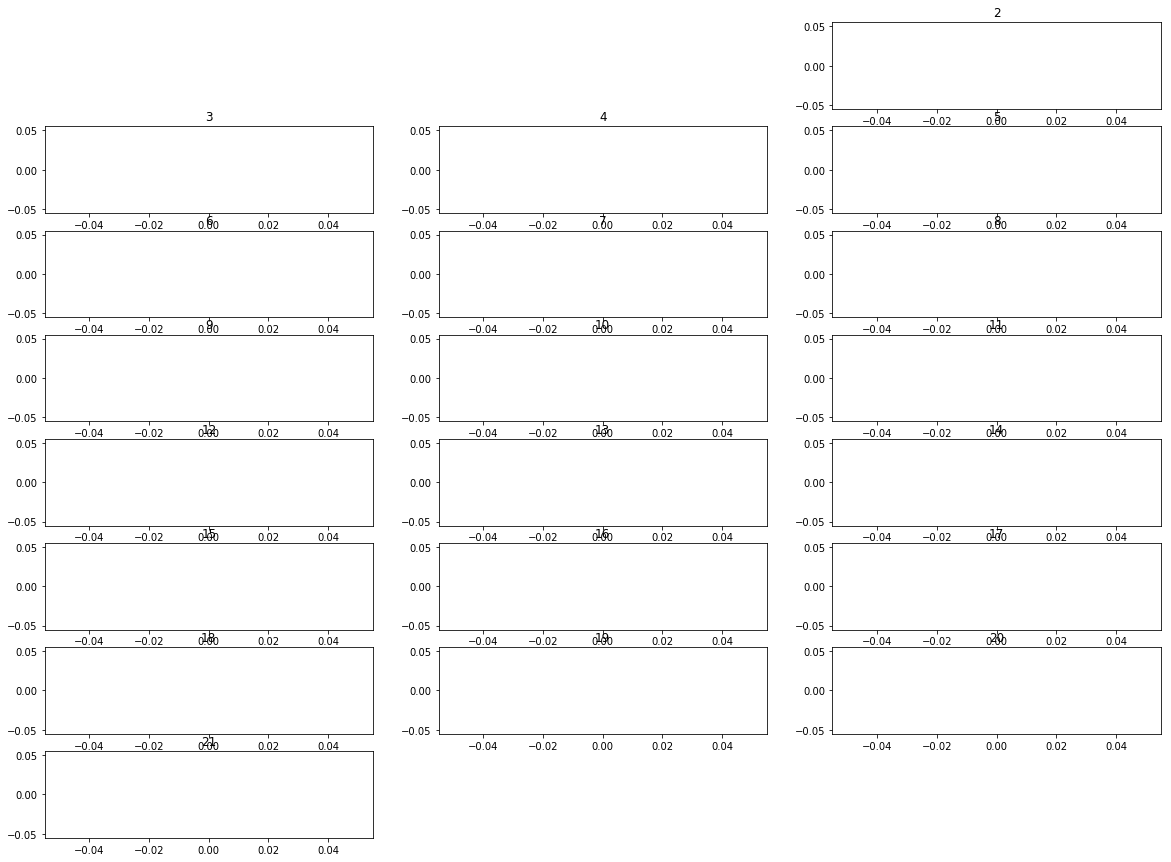

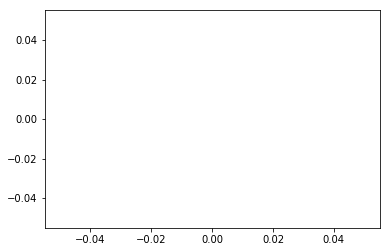

In [187]:

def funcExpDown(x, b):
    return  (np.exp(-b * x)) 
lastDown=89
interval = 22

StartingPoint=2
TR=11
timestamp=np.arange(0,(lastUp)*TR,TR)
poptDown_Signal=np.zeros((interval,3))
SumSq = np.zeros((interval,1))

plt.figure(figsize=(20,15))

for delay in range(StartingPoint,interval):
    MeanPost = np.nanmean(Signal[lastDown-6:lastDown].squeeze())
    SignalC = Signal - MeanPost
    MeanPre = np.nanmean(SignalC[lastUp:StartingPoint+lastUp].squeeze())
    
    Downtake = Signal[lastUp+delay:lastDown].squeeze()/MeanPre
    timestampDown = np.arange(0,Downtake.shape[0]*TR,TR)
    Plateau = Signal[lastUp-10:lastUp].squeeze()

    try:
        poptDown_Signal[delay,:],b=curve_fit(funcExpDown, timestampDown, Downtake, p0=[0.03])
    except:
        poptDown_Signal[delay,:]=[0,10,0]
    #d =funcExpDown(timestampDown,poptDown_Signal[delay,1],poptDown_Signal[delay,2])
    d =(funcExpDown(timestampDown,0.03))*MeanPre +MeanPost
    SignalPre=np.ones((delay))*MeanPre+MeanPost
    
    AllSignal = np.concatenate((SignalPre, d),0)
    SumSq[delay] =  np.nanmean((Signal[lastUp:lastDown] - AllSignal)*(Signal[lastUp:lastDown]  - AllSignal))

    plt.subplot(8,3,delay+1) 
    plt.plot(Signal[lastUp:lastDown])
    plt.plot(AllSignal)
    plt.title(delay)


plt.figure()
plt.plot(SumSq[StartingPoint:interval],'*')
a= np.argmin(SumSq[StartingPoint:interval])+StartingPoint+lastUp
print(a)



/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: Mean of empty slice
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: Mean of empty slice
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: Mean of empty slice


0


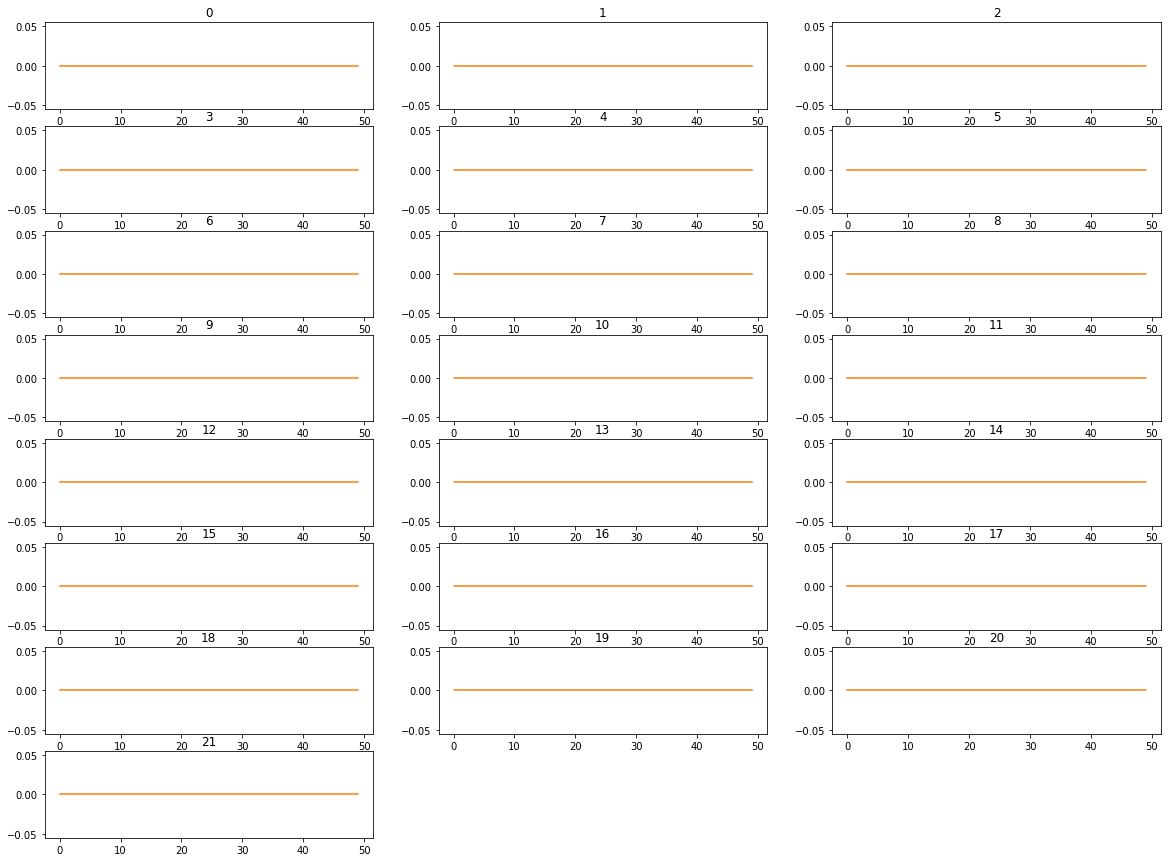

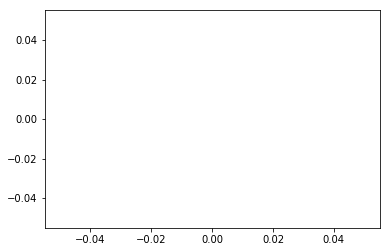

In [188]:
def funcExpUp(x, a, b,c):
    return a * (1-np.exp(-b * x)) +c
def funcExpDown(x, a, b,c):
    return a * (np.exp(-b * x)) +c
lastUp=50
interval = 22
TR=11

timestamp=np.arange(0,(lastUp)*TR,TR)

poptUp_Signal=np.zeros((interval,3))
SumSq = np.zeros((interval,1))
perr=np.zeros((interval,3))
plt.figure(figsize=(20,15))

for delay in range(0,interval):
    Uptake = Signal[delay:lastUp].squeeze()
    timestampUp = np.arange(0,(lastUp-delay)*TR,TR)
    
    Plateau = Signal[lastUp-10:lastUp].squeeze()
    aGuess =np.nanmean( Plateau)
    cGuess= np.nanmean( Signal[1:6].squeeze())
    try:
        poptUp_Signal[delay,:],b=curve_fit(funcExpUp, timestampUp, Uptake, p0=[aGuess,0.03,cGuess])
    except:
        poptUp_Signal[delay,:]=[0,10,0]
    d =funcExpUp(timestampUp,poptUp_Signal[delay,0],poptUp_Signal[delay,1],poptUp_Signal[delay,2])
    SignalPre=np.ones((delay))*poptUp_Signal[delay,2]
 
    AllSignal = np.concatenate((SignalPre, d),0)
    SumSq[delay] =  np.nanmean((Signal[0:lastUp] - AllSignal)*(Signal[0:lastUp]  - AllSignal))

    plt.subplot(8,3,delay+1) 
    plt.plot(Signal)
    plt.plot(AllSignal)
    plt.title(delay)

plt.figure()
plt.plot(SumSq[0:interval],'*')
a= np.argmin(SumSq[0:interval])
print(a+0)


In [174]:
MeanPost

0.49850631891419867

58


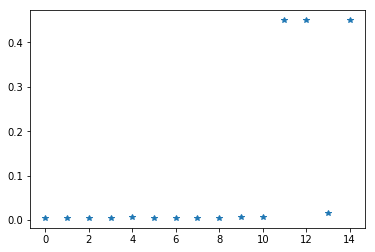

In [154]:
def funcExpDown(x, a, b,c):
    return a * (np.exp(-b * x)) +c
lastDown=89
interval = 22
TR=11
timestamp=np.arange(0,(lastUp)*TR,TR)
PlateauEnd=50
poptDown_Signal=np.zeros((interval,3))
SumSq = np.zeros((interval,1))

plt.figure(figsize=(20,15))

for delay in range(0,interval):
    Downtake = Signal[lastUp+delay:lastDown].squeeze()
    timestampDown = np.arange(0,Downtake.shape[0]*TR,TR)
    Plateau = Signal[lastUp-10:lastUp].squeeze()
    aGuess =np.nanmean( Plateau)
    
    cGuess= np.nanmean( Signal[lastDown-6:lastDown].squeeze())
    try:
        poptDown_Signal[delay,:],b=curve_fit(funcExpDown, timestampDown, Downtake, p0=[aGuess,0.03,cGuess])
    except:
        poptDown_Signal[delay,:]=[0,10,0]
    d =funcExpDown(timestampDown,poptDown_Signal[delay,0],poptDown_Signal[delay,1],poptDown_Signal[delay,2])
    SignalPre=np.ones((delay))*(poptDown_Signal[delay,0] + poptDown_Signal[delay,2])
    
    AllSignal = np.concatenate((SignalPre, d),0)
    SumSq[delay] =  np.nanmean((Signal[lastUp:lastDown] - AllSignal)*(Signal[lastUp:lastDown]  - AllSignal))

    plt.subplot(8,3,delay+1) 
    plt.plot(Signal[lastUp:lastDown])
    plt.plot(AllSignal)
    plt.title(delay)


plt.figure()
plt.plot(SumSq[0:15],'*')
a= np.argmin(SumSq)
print(a+lastUp)
